# 5. Моделирование и эксперименты

## 🎯 Цели этапа
1. Обучить и сравнить различные ML-алгоритмы
2. Провести подбор гиперпараметров для лучших моделей
3. Выбрать оптимальную модель для прогнозирования оттока
4. Проанализировать feature importance

## 📊 Данные для моделирования
- Train: 12,802 наблюдений, 23 признака (после SMOTE)
- Test: 2,001 наблюдение, 23 признака (оригинальное распределение)
- Дисбаланс: 50/50 в train, 80/20 в test

In [1]:
import joblib
import pandas as pd

import sys
import os

os.chdir('..')

sys.path.insert(0, 'src')

from model_training import TrainModels
from hyperparametr_config import MODEL_PARAMS_CONFIG
from hyperparametr_tuner import HyperparametrTuner

os.chdir('notebooks')

X_train = joblib.load('../data/processed/X_train.pkl')
X_test = joblib.load('../data/processed/X_test.pkl')
y_train = joblib.load('../data/processed/y_train.pkl')
y_test = joblib.load('../data/processed/y_test.pkl')

trainer = TrainModels(X_train, X_test, y_train, y_test)

models = trainer.fit_models()

predictions_models = trainer.evaluate_models()

for model_name, metric in predictions_models.items():
    print(f'Модель: {model_name}. Результаты:')
    print(f'\nClassification report:\n{metric["classification_report"]}')
    print('-'*50)

Модель: LogisticRegression. Результаты:

Classification report:
              precision    recall  f1-score   support

           0       0.91      0.76      0.83      1593
           1       0.43      0.70      0.53       408

    accuracy                           0.75      2001
   macro avg       0.67      0.73      0.68      2001
weighted avg       0.81      0.75      0.77      2001

--------------------------------------------------
Модель: KNeighborsClassifier. Результаты:

Classification report:
              precision    recall  f1-score   support

           0       0.89      0.76      0.82      1593
           1       0.41      0.63      0.49       408

    accuracy                           0.74      2001
   macro avg       0.65      0.70      0.66      2001
weighted avg       0.79      0.74      0.75      2001

--------------------------------------------------
Модель: DecisionTreeClassifier. Результаты:

Classification report:
              precision    recall  f1-score   

[I 2025-10-10 13:27:03,273] A new study created in memory with name: no-name-ca167ddd-b6d7-457f-adf7-38f631ffd8ec


🎯 Запуск подбора гиперпараметров для: ['catboost', 'lightgbm']

🔍 Оптимизация catboost...


[I 2025-10-10 13:27:16,001] Trial 0 finished with value: 0.9677142772094951 and parameters: {'iterations': 781, 'depth': 8, 'learning_rate': 0.1205712628744377, 'l2_leaf_reg': 6.387926357773329, 'border_count': 66, 'random_strength': 1.6443457513284063, 'bagging_temperature': 0.05808361216819946}. Best is trial 0 with value: 0.9677142772094951.
[I 2025-10-10 13:27:33,906] Trial 1 finished with value: 0.9661459270340185 and parameters: {'iterations': 1150, 'depth': 7, 'learning_rate': 0.11114989443094977, 'l2_leaf_reg': 1.185260448662222, 'border_count': 249, 'random_strength': 8.341182143924176, 'bagging_temperature': 0.21233911067827616}. Best is trial 0 with value: 0.9677142772094951.
[I 2025-10-10 13:27:41,044] Trial 2 finished with value: 0.9579882182555428 and parameters: {'iterations': 636, 'depth': 4, 'learning_rate': 0.028145092716060652, 'l2_leaf_reg': 5.72280788469014, 'border_count': 128, 'random_strength': 2.983168487960615, 'bagging_temperature': 0.6118528947223795}. Best 

✅ catboost: лучший roc_auc = 0.9678
   Лучшие параметры: {'iterations': 638, 'depth': 8, 'learning_rate': 0.13962563737015762, 'l2_leaf_reg': 9.455490474077703, 'border_count': 232, 'random_strength': 6.019209790229743, 'bagging_temperature': 0.9218742350231168}

🔍 Оптимизация lightgbm...


[I 2025-10-10 13:28:38,309] Trial 0 finished with value: 0.9611323643574081 and parameters: {'n_estimators': 531, 'max_depth': 8, 'learning_rate': 0.1205712628744377, 'num_leaves': 68, 'min_child_samples': 24, 'subsample': 0.662397808134481, 'colsample_bytree': 0.6232334448672797, 'reg_alpha': 8.661761457749352, 'reg_lambda': 6.011150117432088}. Best is trial 0 with value: 0.9611323643574081.
[I 2025-10-10 13:28:40,721] Trial 1 finished with value: 0.9611953925876595 and parameters: {'n_estimators': 914, 'max_depth': 3, 'learning_rate': 0.2708160864249968, 'num_leaves': 87, 'min_child_samples': 29, 'subsample': 0.6727299868828402, 'colsample_bytree': 0.6733618039413735, 'reg_alpha': 3.0424224295953772, 'reg_lambda': 5.247564316322379}. Best is trial 1 with value: 0.9611953925876595.
[I 2025-10-10 13:28:43,098] Trial 2 finished with value: 0.9597249980779656 and parameters: {'n_estimators': 597, 'max_depth': 4, 'learning_rate': 0.08012737503998542, 'num_leaves': 31, 'min_child_samples':

✅ lightgbm: лучший roc_auc = 0.9612
   Лучшие параметры: {'n_estimators': 914, 'max_depth': 3, 'learning_rate': 0.2708160864249968, 'num_leaves': 87, 'min_child_samples': 29, 'subsample': 0.6727299868828402, 'colsample_bytree': 0.6733618039413735, 'reg_alpha': 3.0424224295953772, 'reg_lambda': 5.247564316322379}
✅ Добавлено 2 настроенных моделей

🏆 Лучшая модель: CatBoostClassifier с ROC-AUC = 0.8625


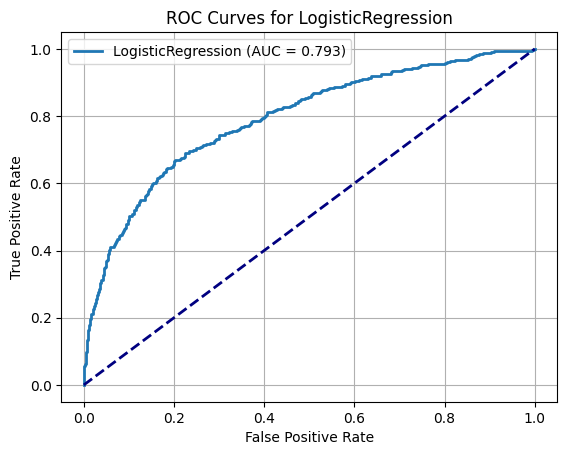

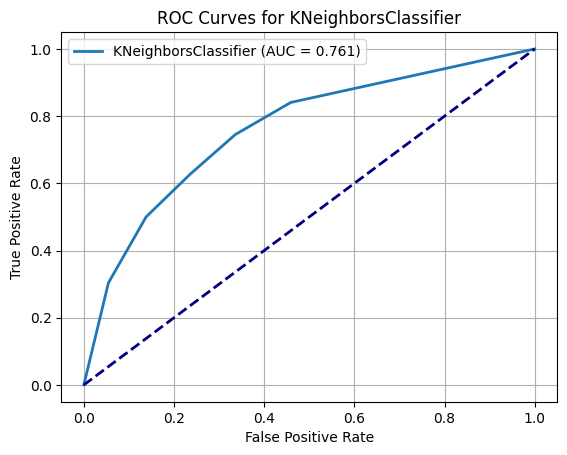

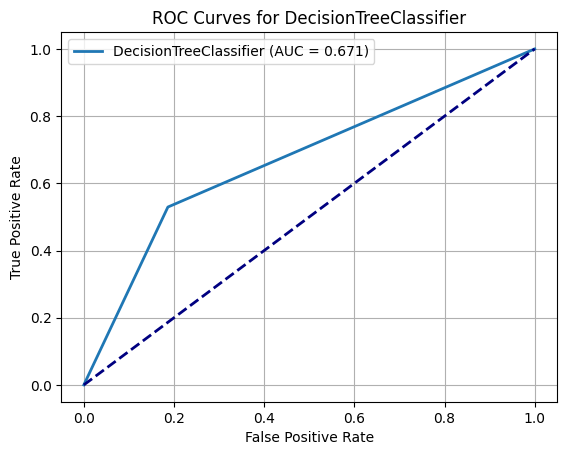

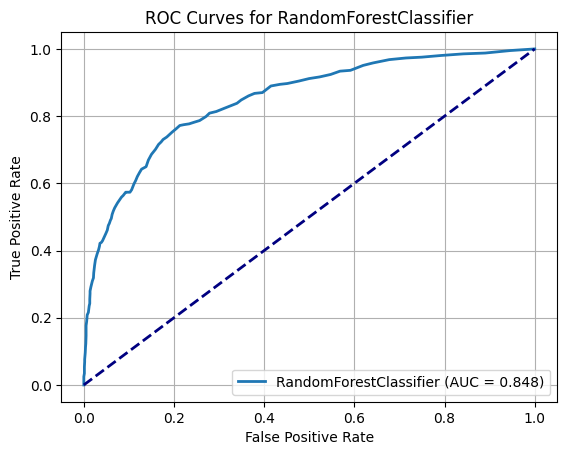

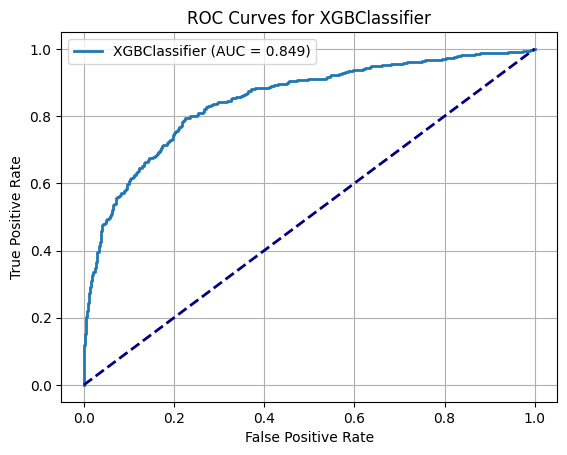

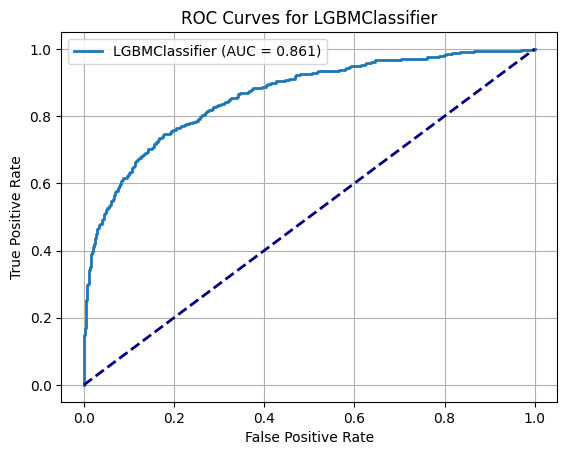

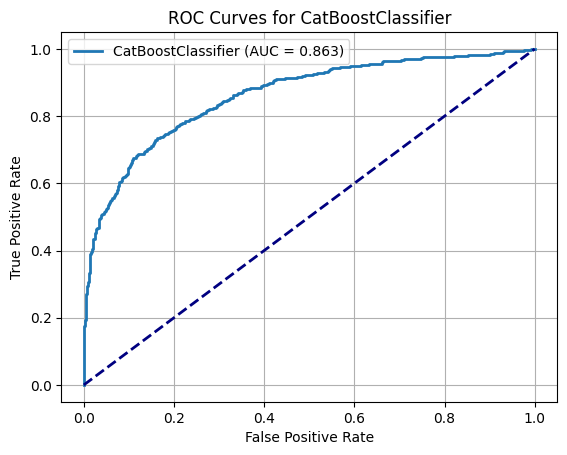

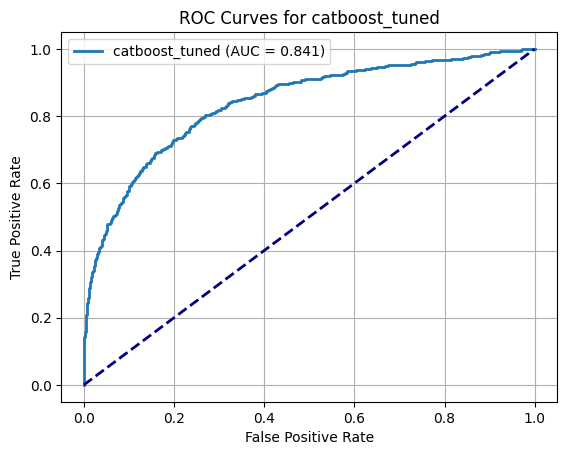

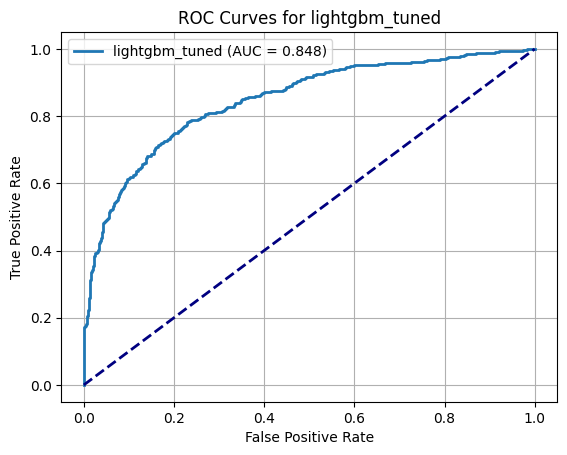

In [2]:
tuner = HyperparametrTuner(
    X_train=X_train,
    y_train=y_train,
    params_config=MODEL_PARAMS_CONFIG,
    n_trials=10
)

best_models_to_tune = ['catboost', 'lightgbm']
best_params = tuner.tune_models(models_to_tune=best_models_to_tune)

tuned_models = tuner.get_tuned_models()

trainer.add_tuned_models(tuned_models)

all_predictions = trainer.evaluate_models()

best_model, best_score = trainer.get_best_model()
print(f"\n🏆 Лучшая модель: {best_model} с ROC-AUC = {best_score:.4f}")

trainer.plot_roc_curve()